## 1. Mục tiêu bài toán

Mục tiêu của bài toán là xây dựng một pipeline phân tích dữ liệu kinh doanh
và dự báo biến động giá cổ phiếu trong ngắn hạn.

Bài toán này phục vụ cho:
- Hỗ trợ quyết định đầu tư (mua / bán)
- Phân tích rủi ro thị trường
- Đánh giá tác động của các yếu tố vĩ mô và tâm lý thị trường

Chiến lược tiếp cận:
- Không dự báo trực tiếp giá
- Dự báo log-return (ổn định hơn, ít nhiễu)
- Sử dụng Machine Learning (Random Forest)


## 2. Cài đặt thư viện cần thiết

In [25]:

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

from model.RandomForest import RandomForest

## 3. Thu thập dữ liệu

Dữ liệu được thu thập từ Yahoo Finance, bao gồm:
- Giá cổ phiếu
- Dữ liệu vĩ mô: VIX, S&P500, USD Index
- Thời gian: 2016 – 2025
- Tần suất: ngày

In [26]:
ticker = "AAPL"
start_date = "2016-01-01"
end_date = "2025-12-31"
df = yf.download(ticker, start=start_date, end=end_date)
df.columns = df.columns.droplevel(1)
display(df.head())

/tmp/ipykernel_15605/2931531061.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,23.753151,23.757661,22.997830,23.135367,270597600
2016-01-05,23.157911,23.865884,23.090272,23.843337,223164000
2016-01-06,22.704725,23.081260,22.517587,22.673160,273829600
2016-01-07,21.746479,22.576205,21.741970,22.249276,324377600
2016-01-08,21.861467,22.346226,21.816374,22.219964,283192000


## 4. Mô tả dữ liệu

Quan sát thống kê mô tả để hiểu:
- Phân bố giá
- Độ biến động
- Các giá trị bất thường

In [27]:
display(df.describe())

Price,Close,High,Low,Open,Volume
count,2513.000000,2513.000000,2513.000000,2513.000000,2.513000e+03
mean,114.228925,115.361321,112.980904,114.119154,1.018063e+08
std,73.297719,73.993144,72.525798,73.223924,5.796751e+07
min,20.604084,20.907414,20.405662,20.526533,1.791060e+07
25%,41.530762,41.797315,41.136559,41.510493,6.177760e+07
50%,120.293777,121.717129,118.782673,120.557001,8.879280e+07
75%,171.629944,173.118379,169.739566,171.372045,1.244862e+08
max,286.190002,288.619995,283.299988,286.200012,5.334788e+08


### Biểu đồ giá đóng cửa

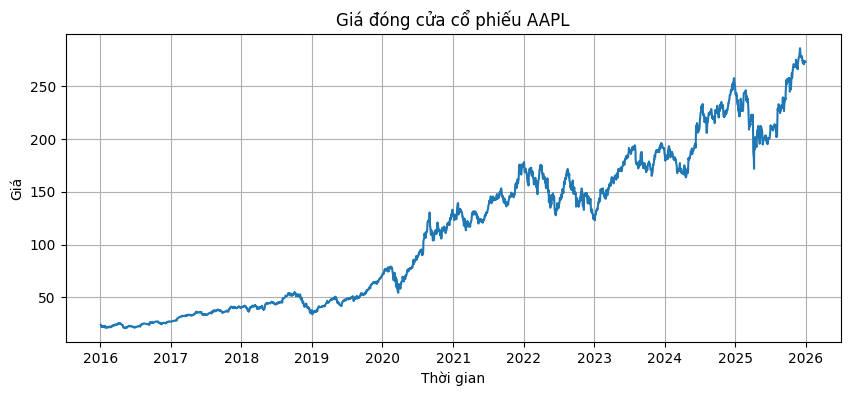

In [28]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df['Close'])
plt.title('Giá đóng cửa cổ phiếu AAPL')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.grid(True)
plt.show()

## 5. Bổ sung dữ liệu vĩ mô

Các yếu tố vĩ mô ảnh hưởng mạnh tới cổ phiếu:
- VIX: đo lường nỗi sợ thị trường
- S&P500: xu hướng thị trường chung
- USD Index: sức mạnh đồng USD

In [29]:
macro_tickers = ['^VIX', '^GSPC', 'DX-Y.NYB']
macro_data = yf.download(macro_tickers, start=start_date, end=end_date)['Close']
macro_data.columns = ['vix_close', 'sp500_close', 'dxy_close']

df = df.join(macro_data, how='left')
df[['vix_close', 'sp500_close', 'dxy_close']] = df[['vix_close', 'sp500_close', 'dxy_close']].ffill()

/tmp/ipykernel_15605/190155378.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  macro_data = yf.download(macro_tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


### Tạo biến động vĩ mô

In [30]:
df['vix_change'] = df['vix_close'].diff()
df['sp500_return'] = df['sp500_close'].pct_change()
df['dxy_return'] = df['dxy_close'].pct_change()

## 6. Feature Engineering

Tạo các đặc trưng phản ánh:
- Xu hướng
- Biến động
- Tâm lý thị trường
- Dòng tiền

In [31]:
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df['volatility_5'] = df['log_return'].rolling(5).std()
df['ma_5'] = df['Close'].rolling(5).mean()
df['ma_10'] = df['Close'].rolling(10).mean()
df['high_low_range'] = (df['High'] - df['Low']) / df['Close']
df['open_close_change'] = (df['Close'] - df['Open']) / df['Open']

## 7. Chỉ báo kỹ thuật nâng cao

Các chỉ báo giúp mô hình nhận diện:
- Quá mua / quá bán
- Động lượng giá
- Xu hướng

In [32]:
# RSI 14
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
loss = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()
rs = gain / loss
df['rsi_14'] = 100 - (100 / (1 + rs))

#MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema_12 - ema_26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# OBV
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

## 8. Tiền xử lý & tạo nhãn

Target là log-return của ngày kế tiếp (t+1)

In [34]:
df = df.dropna()
df['target'] = df['log_return'].shift(-1)
df = df.dropna()

display(df.head())
display(df.describe())

,Close,High,Low,Open,Volume,vix_close,sp500_close,dxy_close,vix_change,sp500_return,...,volatility_5,ma_5,ma_10,high_low_range,open_close_change,rsi_14,macd,macd_signal,obv,target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-15,21.899799,22.030572,21.500720,21.690113,319335600,98.959999,1880.329956,27.020000,-0.129997,-0.021599,...,0.023465,22.210046,22.427396,0.024194,0.009667,33.689849,-0.447400,-0.323967,-459018400.0,-0.004850
2016-01-19,21.793835,22.242518,21.532290,22.188405,212350800,98.989998,1881.329956,26.049999,0.029999,0.000532,...,0.021766,22.125722,22.231465,0.032588,-0.017783,32.186696,-0.474658,-0.354105,-671369200.0,0.001344
2016-01-20,21.823143,22.138800,21.063312,21.442100,289337600,99.089996,1859.329956,27.590000,0.099998,-0.011694,...,0.019717,21.982774,22.097988,0.049282,0.017771,33.138739,-0.488267,-0.380938,-382031600.0,-0.005076
2016-01-21,21.712660,22.068899,21.406022,21.884015,208646000,99.059998,1868.989990,26.690001,-0.029999,0.005195,...,0.016467,21.933621,21.998781,0.030530,-0.007830,31.231573,-0.502178,-0.405186,-590677600.0,0.051802
2016-01-22,22.867062,22.876081,22.179382,22.238003,263202000,99.570000,1906.900024,22.340000,0.510002,0.020284,...,0.028521,22.019300,22.110840,0.030467,0.028288,59.400943,-0.415266,-0.407202,-327475600.0,-0.019716


,Close,High,Low,Open,Volume,vix_close,sp500_close,dxy_close,vix_change,sp500_return,...,volatility_5,ma_5,ma_10,high_low_range,open_close_change,rsi_14,macd,macd_signal,obv,target
count,2503.000000,2503.000000,2503.000000,2503.000000,2.503000e+03,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,...,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2.503000e+03,2503.000000
mean,114.495339,115.630358,113.243632,114.384663,1.012960e+08,98.510575,3774.485344,18.483696,-0.000419,0.000576,...,0.015283,114.294596,114.044556,0.020161,0.001065,56.101318,0.700112,0.698056,4.970926e+09,0.001008
std,73.168263,73.864581,72.395900,73.095403,5.730274e+07,5.033528,1287.883687,7.339753,0.423698,0.011409,...,0.010437,73.045101,72.899121,0.012048,0.014091,17.283704,2.423286,2.273465,2.427509e+09,0.018260
min,20.604084,20.907414,20.405662,20.526533,1.791060e+07,88.589996,1829.079956,9.140000,-2.340004,-0.119841,...,0.000904,20.963520,21.131610,0.004382,-0.076486,8.878106,-10.593850,-8.307522,-1.223293e+09,-0.137708
25%,41.612089,41.982087,41.349343,41.610171,6.174550e+07,94.709999,2715.045044,13.510000,-0.239998,-0.003584,...,0.008393,41.646592,41.487870,0.012468,-0.006046,42.767873,-0.401094,-0.374522,3.188233e+09,-0.007053
50%,120.878708,121.992244,119.162885,120.761716,8.863680e+07,97.790001,3690.010010,16.680000,0.000000,0.000758,...,0.012629,120.334718,119.556741,0.017208,0.001100,57.438152,0.536882,0.482737,5.890486e+09,0.001096
75%,171.676315,173.177331,169.789815,171.511488,1.239198e+08,102.450001,4514.469971,21.485000,0.240005,0.005801,...,0.019211,171.340158,171.417183,0.024189,0.008569,69.952341,1.969835,1.899759,6.716928e+09,0.009973
max,286.190002,288.619995,283.299988,286.200012,5.334788e+08,114.110001,6932.049805,82.690002,1.919998,0.095154,...,0.108266,282.598004,280.365002,0.144430,0.156441,94.160766,8.894987,8.264068,8.976859e+09,0.142618


## 9. Phân tích tương quan


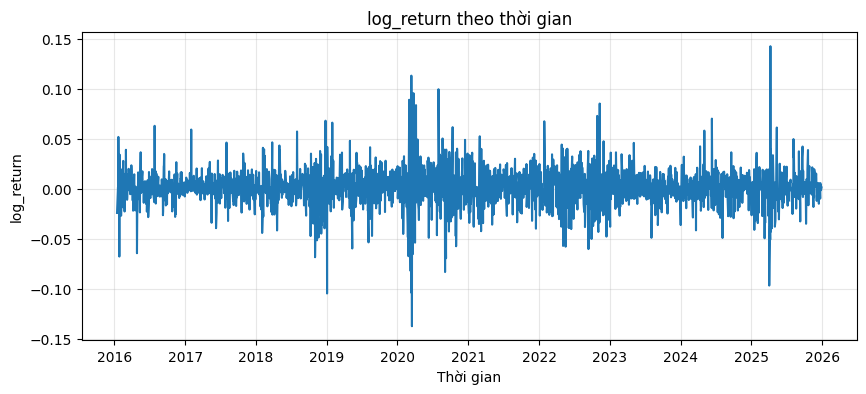

In [62]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df['log_return'])
plt.title('log_return theo thời gian')
plt.xlabel('Thời gian')
plt.ylabel('log_return')
plt.grid(alpha=0.3)
plt.show()

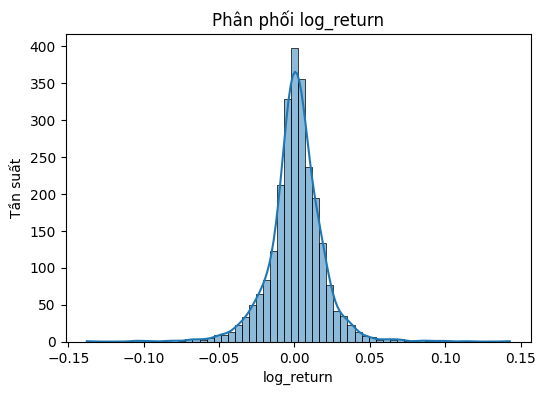

In [63]:
plt.figure(figsize=(6,4))
sns.histplot(df['log_return'], bins=60, kde=True)
plt.title('Phân phối log_return')
plt.xlabel('log_return')
plt.ylabel('Tần suất')
plt.show()

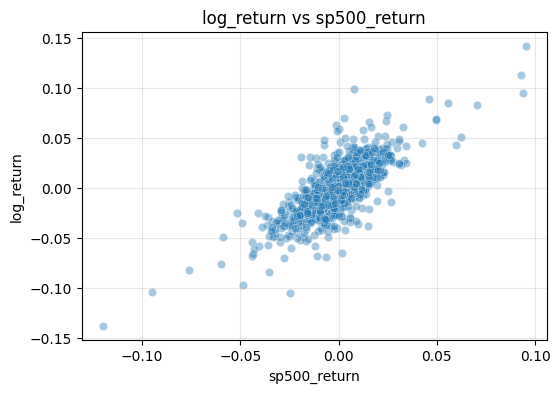

In [64]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=df['sp500_return'],
    y=df['log_return'],
    alpha=0.4
)
plt.title('log_return vs sp500_return')
plt.xlabel('sp500_return')
plt.ylabel('log_return')
plt.grid(alpha=0.3)
plt.show()

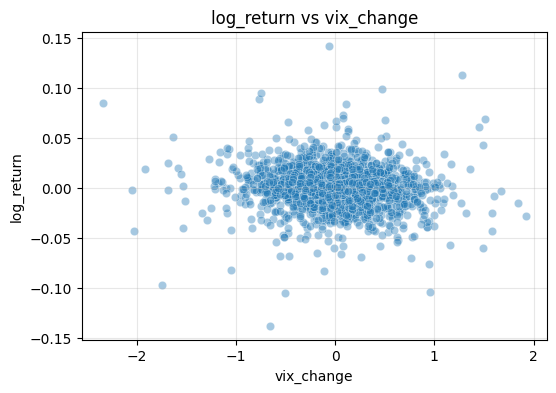

In [65]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=df['vix_change'],
    y=df['log_return'],
    alpha=0.4
)
plt.title('log_return vs vix_change')
plt.xlabel('vix_change')
plt.ylabel('log_return')
plt.grid(alpha=0.3)
plt.show()

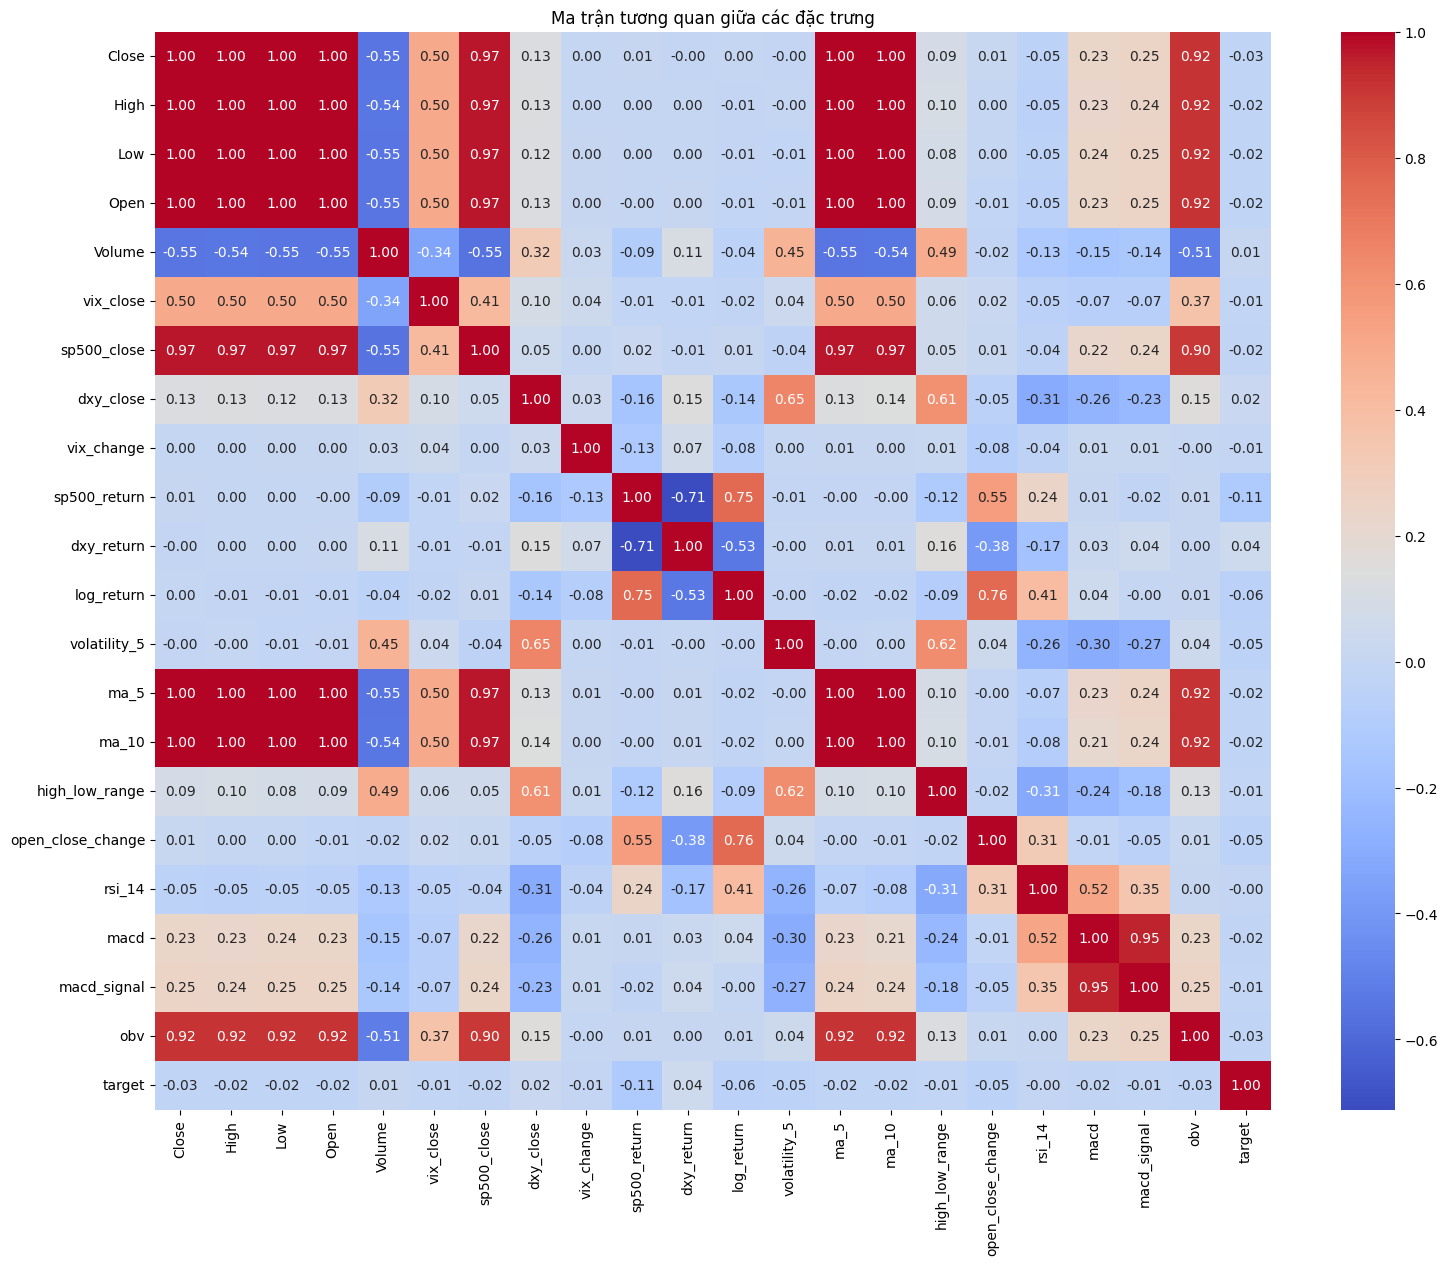

In [35]:
plt.figure(figsize=(18, 14))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các đặc trưng")
plt.show()

In [36]:
selected_features = [
    'Close',
    'log_return',
    'sp500_return',
    'vix_change',
    'open_close_change',
    'obv',
    'ma_5',
    'volatility_5',
]

## 9. Train/Test Split theo thời gian

In [37]:
X = df[selected_features].values
y = df['target'].values

split_idx = int(len(X) * 0.85)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

## 10. Mô hình Random Forest

- Số cây quyết định: 100 cây
- Độ sâu tối đa mỗi cây: 10
- Số mẫu tối thiểu để chia node: 5
- Số đặc trưng xét tại mỗi node: X.shape[1] / 3
- Thiết lập random seed: 42
- Huấn luyện song song: sử dụng toàn bộ CPU (n_jobs = -1)
- Target dự đoán: log_return (t+1)

In [38]:
rf = RandomForest(
    n_trees=100,
    max_depth=10,
    min_samples_split=5,
    n_features=int(X.shape[1]/3),
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

## 11. Đánh giá mô hình và trực quan hoá

Đánh giá trên:
- Sai số giá
- Sai số %
- Độ chính xác xu hướng

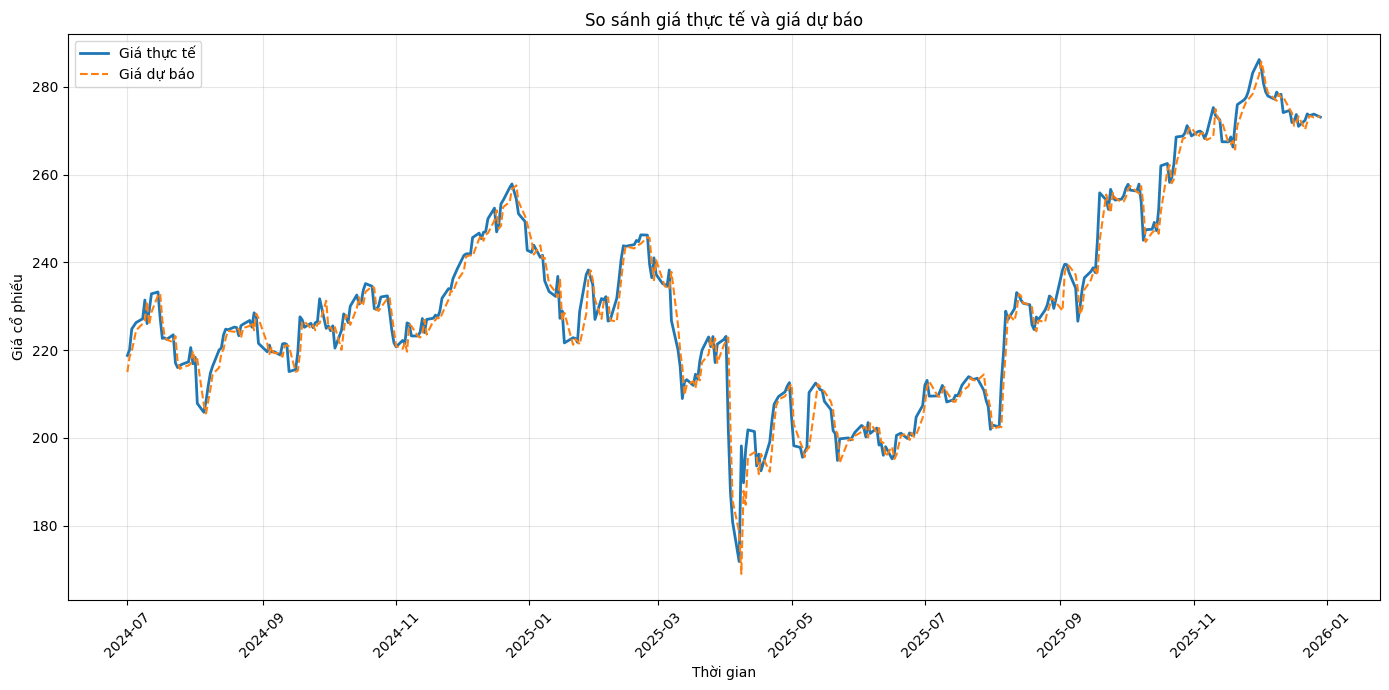

In [46]:

y_pred = rf.predict(X_test)

base_prices = X_test[:, selected_features.index('Close')]

predicted_prices = base_prices * np.exp(y_pred)
actual_prices = base_prices * np.exp(y_test)

dates_test = df.index[split_idx:]

plt.figure(figsize=(14, 7))
plt.plot(dates_test, actual_prices, label='Giá thực tế', linewidth=2)
plt.plot(dates_test, predicted_prices, label='Giá dự báo', linestyle='--')

plt.title('So sánh giá thực tế và giá dự báo')
plt.xlabel('Thời gian')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [53]:
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = np.mean(np.abs((actual_prices - predicted_prices)/actual_prices)) * 100

direction_acc = np.mean(np.sign(y_pred) == np.sign(y_test)) * 100

print(f"RMSE:                     {rmse:.4f}")
print(f"MAPE:                     {mape:.2f}%")
print(f"Directional Accuracy:     {direction_acc:.2f}%")



RMSE:                     3.9658
MAPE:                     1.20%
Directional Accuracy:     45.21%


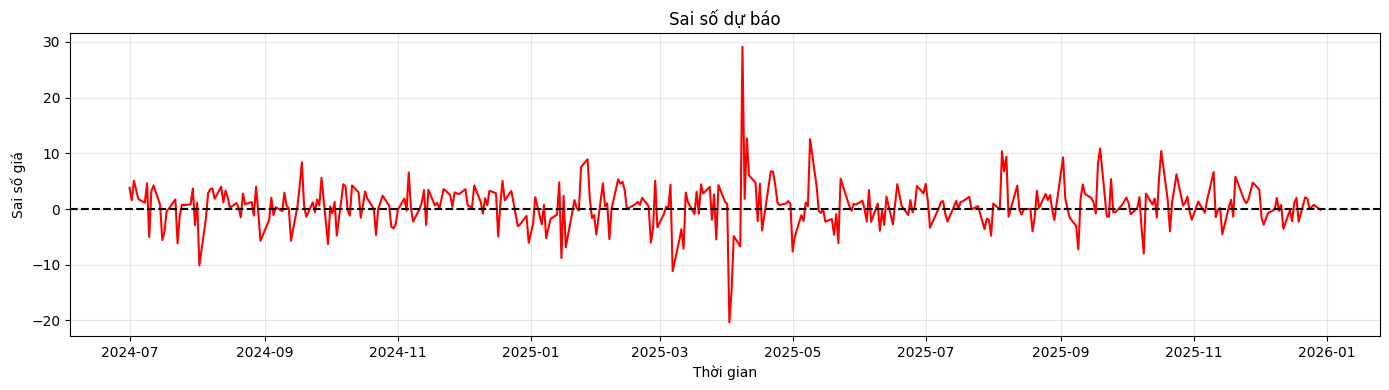

In [55]:
errors = actual_prices - predicted_prices

plt.figure(figsize=(14, 4))
plt.plot(dates_test, errors, color='red')
plt.axhline(0, linestyle='--', color='black')

plt.title('Sai số dự báo')
plt.xlabel('Thời gian')
plt.ylabel('Sai số giá')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
